# Wavefront Calculation Strategy Comparison

This notebook demonstrates the different reference strategies available in Optiland for calculating Optical Path Difference (OPD) wavefront errors. The computed wavefront error depends significantly on how the reference geometry (sphere or plane) is defined relative to the actual wavefront.

We will explore strategies for both **Focal Systems** (where the reference is a sphere) and **Afocal Systems** (where the reference is a plane).

## Quick Summary of Strategies

| Strategy | Reference Geometry | Description | Interpretation |
| :--- | :--- | :--- | :--- |
| **Chief Ray** | Sphere / Plane | Centered/Oriented based on the chief ray intersection and direction. | Preserves tilt and defocus. Reports absolute error relative to the chief ray. |
| **Centroid** | Sphere / Plane | Centered on the centroid of the rays; radius/orientation based on weighted average. | Removes tilt (mostly). Good balance for general quality assessment. |
| **Best Fit** | Sphere / Plane | Least-squares fit to the actual wavefront points. | Removes tilt and defocus (for spheres) or tilt (for planes). Reports minimum RMS error. |


In [1]:
import matplotlib.pyplot as plt
import optiland.backend as be
from optiland import optic
from optiland.samples.objectives import DoubleGauss
from optiland.wavefront import OPD

## 1. Focal Systems (Reference Sphere)

For focal systems like photographic objectives, the wavefront is compared to a specific reference sphere. The center and radius of this sphere determine which aberration terms (tilt, defocus) are included in the OPD.

We use a `DoubleGauss` lens for this demonstration.

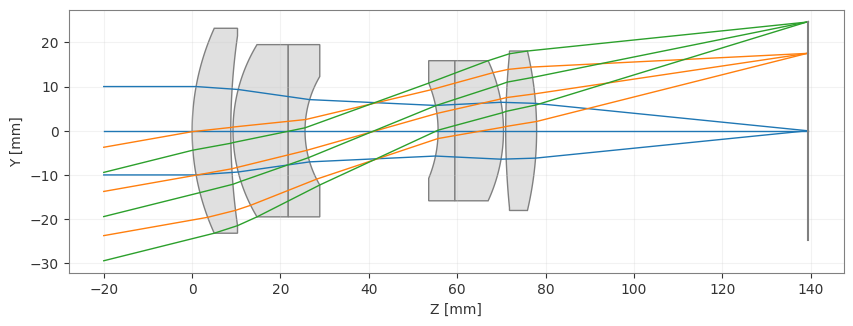

In [2]:
lens = DoubleGauss()
_ = lens.draw()

### Comparing Strategies

We will compute the OPD using three strategies:
1.  **Chief Ray**: Reference sphere centered at chief ray intersection.
2.  **Centroid**: Reference sphere centered at the centroid of ray intersections.
3.  **Best Fit**: Reference sphere fitted to the wavefront (minimizes RMS).

Typically, `chief_ray >= centroid >= best_fit` in terms of RMS error.

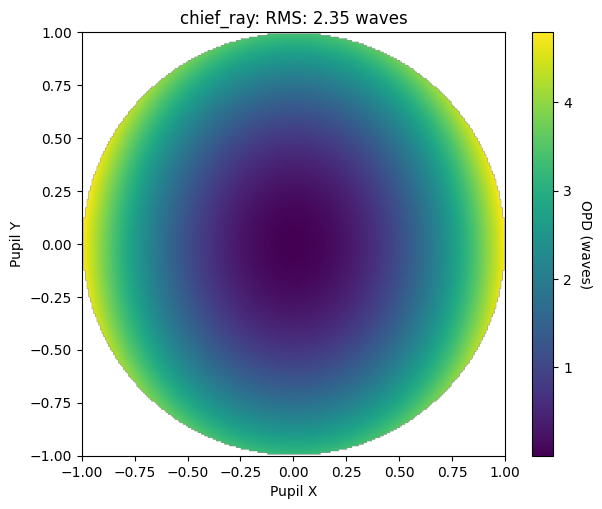

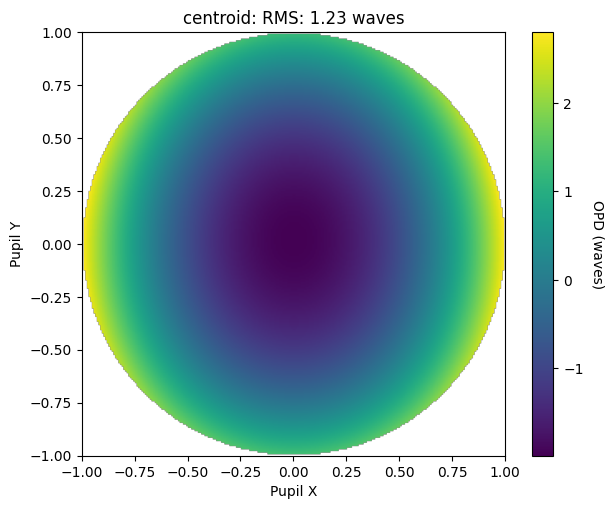

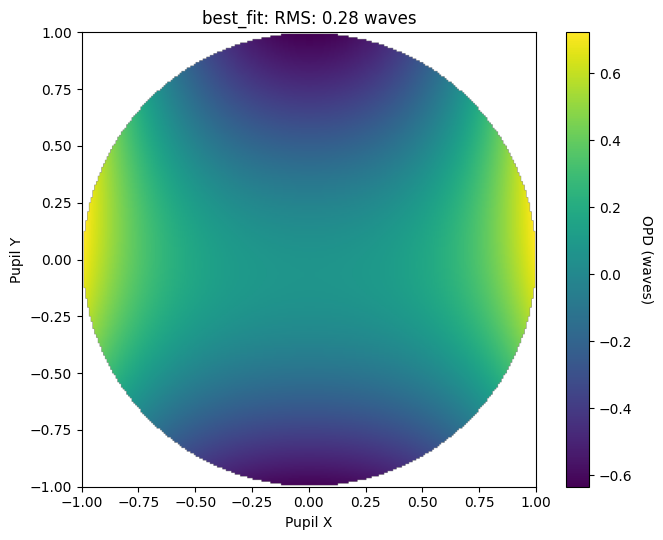

In [3]:
strategies = ["chief_ray", "centroid", "best_fit"]

for i, strat in enumerate(strategies):
    opd = OPD(lens, field=(0, 1), wavelength="primary", num_rays=128, strategy=strat)
    rms = opd.rms()
    fig, ax = opd.view()
    ax.set_title(f"{strat}: RMS: {rms:.2f} waves")

plt.tight_layout()
plt.show()

## 2. Afocal Systems (Reference Plane)

For afocal systems (like beam expanders), the output wavefront is nominally planar. Here, the reference geometry is a **plane**.

The strategies adapt as follows:
- **Chief Ray**: Reference plane perpendicular to the chief ray.
- **Best Fit**: Reference plane least-squares fitted to the wavefront points.

To enable this, we set `afocal=True` when creating the `OPD` object.

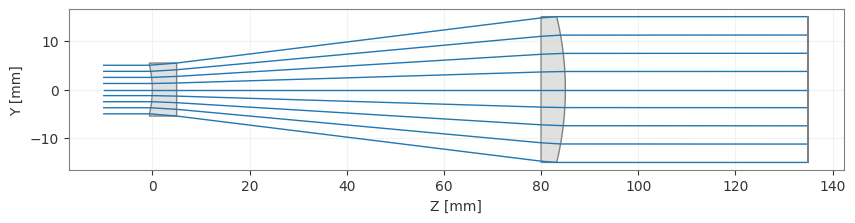

In [4]:
# Define a Beam Expander
beam_expander = optic.Optic()

# Properties
radius_start = 5
radius_end = 15

# Add surfaces
beam_expander.add_surface(index=0, thickness=be.inf)
beam_expander.add_surface(index=1, thickness=5, radius=-21.3565, material="N-BK7", is_stop=True)
beam_expander.add_surface(index=2, thickness=75, radius=be.inf)
beam_expander.add_surface(index=3, thickness=5, radius=be.inf, material="N-BK7")
beam_expander.add_surface(index=4, thickness=50, radius=-64.0697)
beam_expander.add_surface(index=5)

# Set aperture
beam_expander.set_aperture(aperture_type="EPD", value=2 * radius_start)

# Add field (angular field for afocal inputs)
beam_expander.set_field_type(field_type="angle")
beam_expander.add_field(y=0.0)  # On-axis

# Add wavelength
beam_expander.add_wavelength(value=0.633, is_primary=True)

_ = beam_expander.draw(num_rays=9)

### Comparing Afocal Strategies

We compare `chief_ray` vs `best_fit` for an off-axis field point. The `best_fit` strategy will remove any residual global tilt in the wavefront, showing only the higher-order deformation.

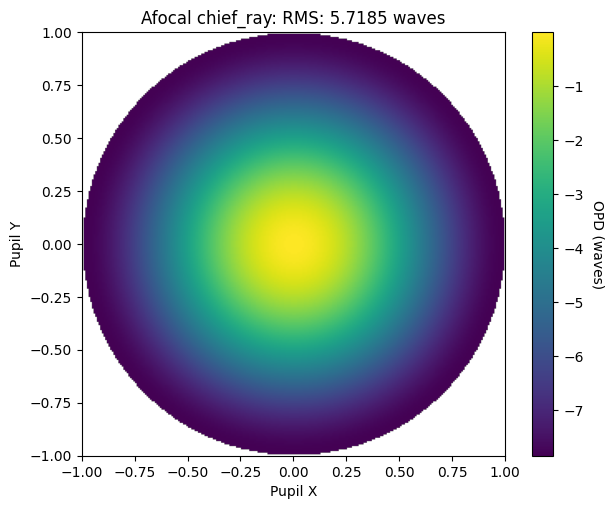

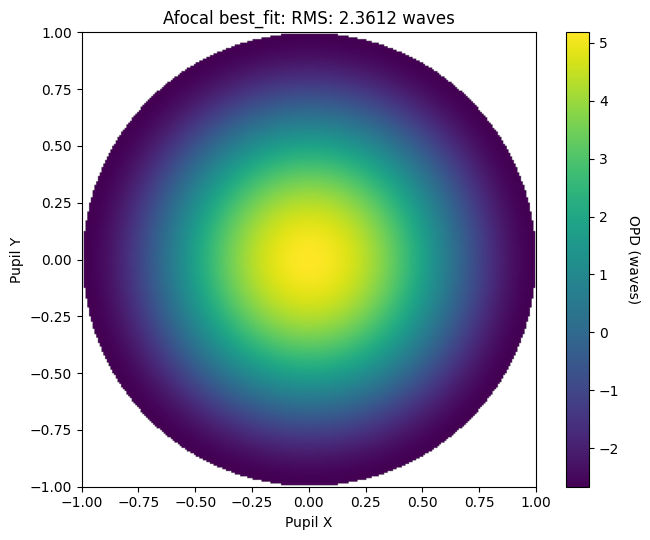

In [5]:
afocal_strategies = ["chief_ray", "best_fit"]

for i, strat in enumerate(afocal_strategies):
    # Note: We pass afocal=True to switch to planar reference geometry
    opd = OPD(
        beam_expander,
        field=(0, 0),
        wavelength="primary",
        num_rays=128,
        strategy=strat,
        afocal=True  # Important for afocal systems!
    )
    rms = opd.rms()
    
    fig, ax = opd.view()
    ax.set_title(f"Afocal {strat}: RMS: {rms:.4f} waves")
    
plt.tight_layout()
plt.show()